### Mind the backend
This seminar was meant for taito-GPU cluster and __not the Everware__ nodes you used throughout the course.

- One can still run it on Everware node after changing data paths, but it will probably take longer without a GPU

In [1]:
import random
gpuid = random.randint(0,3)
import os
print "random GPU roll: ",gpuid
os.environ["THEANO_FLAGS"]="device=gpu%i"%gpuid


random GPU roll:  1


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import theano
import theano.tensor as T
import lasagne

Using gpu device 1: Tesla K80 (CNMeM is disabled, cuDNN 4007)


# Load the challenge data
* Currently we are using raw data features with no preprocessing in hope that NN figures that out
* One may try any feature engineering he wants

In [3]:
import pandas as pd
df = pd.DataFrame.from_csv("/homeappl/home/austyuzh/data/train_small.csv",)
n_features = df.shape[1]-1

In [62]:
jet_pt   = ['jet1_pt', 'jet2_pt', 'jet3_pt', 'jet4_pt']
jet_eta  = ['jet1_eta', 'jet2_eta', 'jet3_eta', 'jet4_eta']
jet_phi  = ['jet1_phi', 'jet2_phi', 'jet3_phi', 'jet4_phi']
jet_btag = ['jet1_btag', 'jet2_btag', 'jet3_btag', 'jet4_btag']

allvars = [jet_pt, jet_eta, jet_phi, jet_btag]

dfa = np.argsort(df[jet_pt])                             #argsort indices
dfs = df.copy()                                          #sorted jets dataframe
indexer = np.arange(dfs[jet_pt].shape[0])[:,np.newaxis]  #index that help us sort the matrix
                                                         #column vector of range 0->n_entries
for v in allvars:
    dfs[v] = dfs[v].values[indexer, dfa]

y = df['target'].values==1
X = df[df.columns[1:]].values.astype(theano.config.floatX)

In [63]:
from sklearn.cross_validation import train_test_split
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=1337)

# NN architecture
 * We take a simple NN with __3 hidden layers__:
     * Layers must contain 500 hidden units each
     * Layers must use __tanh__ nonlinearity
 * structure can be farther optimized, so feel free to experiment __after__ you got it working

In [64]:
input_X = T.matrix('input X')
target_Y = T.ivector('target Y')

In [65]:
from lasagne.layers import InputLayer,DenseLayer,batch_norm,dropout

In [66]:
l_in = InputLayer([None, n_features],input_X,'input layer')

n_hid = 300

n_l_in = batch_norm(l_in)

l_1 = DenseLayer(n_l_in,
                num_units=n_hid/3,
                name='dense1',
                nonlinearity=lasagne.nonlinearities.tanh)

n_l_1 = batch_norm(l_1)

l_2 = DenseLayer(n_l_1,
                num_units=n_hid/3,
                name='dense2',
                nonlinearity=lasagne.nonlinearities.tanh)

n_l_2 = batch_norm(l_2)

l_3 = DenseLayer(n_l_2,
                num_units=n_hid/3,
                name='dense3',
                nonlinearity=lasagne.nonlinearities.tanh)
                 
n_l_3 = batch_norm(l_3)

nn = DenseLayer(n_l_3,num_units=2,
                name='dense out',
                nonlinearity=lasagne.nonlinearities.softmax,)

In [67]:
weights = lasagne.layers.get_all_params(nn,trainable=True)
weights

[input layer_bn.beta,
 input layer_bn.gamma,
 dense1.W,
 dense1_bn.beta,
 dense1_bn.gamma,
 dense2.W,
 dense2_bn.beta,
 dense2_bn.gamma,
 dense3.W,
 dense3_bn.beta,
 dense3_bn.gamma,
 dense out.W,
 dense out.b]

# weight updates

In [68]:
nn_out = lasagne.layers.get_output(nn)
loss = lasagne.objectives.categorical_crossentropy(nn_out, target_Y).mean()

In [69]:
updates =lasagne.updates.adadelta(loss,weights)
train_fun = theano.function([input_X,target_Y],[loss,nn_out[:,1]],updates=updates)

# deterministic predict

In [70]:
det_nn_out = lasagne.layers.get_output(nn,deterministic=True)
det_loss = lasagne.objectives.categorical_crossentropy(det_nn_out,target_Y).mean()
val_fun = theano.function([input_X,target_Y],[det_loss,nn_out[:,1]])

# training loop
* Almost identical to the original loop from previous seminar
* The only difference is that now we keep track of NN performance across iterations

In [71]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=True):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [72]:
train_auc_curve = []
train_acc_curve = []
val_auc_curve = []
val_acc_curve = []

In [ ]:
num_epochs = 50
batch_size=2000

import time
from sklearn.metrics import roc_auc_score,accuracy_score

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:

    start_time = time.time()
    
    train_err = 0
    Ypred_batches = []
    Ytrue_batches = []
    train_batches = 0
    
    for batch in iterate_minibatches(X_train, y_train, batch_size, shuffle=True):
        inputs, targets = batch
        err, y_pred = train_fun(inputs, targets)
        
        Ypred_batches.append(y_pred)
        Ytrue_batches.append(targets)
        
        train_err += err
        train_batches += 1
    
    Ypred_train = np.concatenate(Ypred_batches)
    Ytrue_train = np.concatenate(Ytrue_batches)
    train_acc = accuracy_score(Ytrue_train, Ypred_train>0.5)
    train_auc = roc_auc_score(Ytrue_train, Ypred_train)
    
    train_acc_curve.append(train_acc)
    train_auc_curve.append(train_auc)


    # And a full pass over the validation data:
    val_err = 0
    Ypred_batches = []
    Ytrue_batches = []
    val_batches = 0
    
    for batch in iterate_minibatches(X_val, y_val, batch_size, shuffle=False):
        inputs, targets = batch
        err, y_pred = val_fun(inputs, targets)
        Ypred_batches.append(y_pred)
        Ytrue_batches.append(targets)
        
        val_err += err
        val_batches += 1

    Ypred_val = np.concatenate(Ypred_batches)
    Ytrue_val = np.concatenate(Ytrue_batches)
    val_acc = accuracy_score(Ytrue_val, Ypred_val>0.5)
    val_auc = roc_auc_score(Ytrue_val, Ypred_val)
    
    val_acc_curve.append(val_acc)
    val_auc_curve.append(val_auc)


    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
    print("  training accuracy:\t\t{:.2f} %".format(
        train_acc * 100))
    print("  training AUCscore:\t\t{:.2f} %".format(
        train_auc * 100))
    print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc  * 100))
    print("  validation AUCscore:\t\t{:.2f} %".format(
        val_auc * 100))

    
    


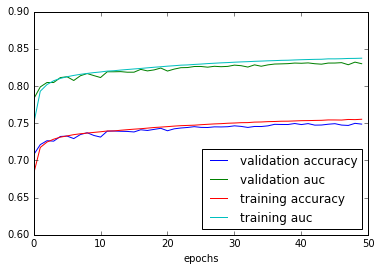

In [30]:
plt.plot(val_acc_curve,label='validation accuracy')
plt.plot(val_auc_curve,label='validation auc')
plt.plot(train_acc_curve,label='training accuracy')
plt.plot(train_auc_curve,label='training auc')
plt.xlabel("epochs")
plt.legend(loc='best')
plt.ylim(0.6,0.9);

In [ ]:
from sklearn.metrics import roc_curve
plt.title('Resulting ROC curves')

fpr,tpr,_ = roc_curve(Ytrue_val,Ypred_val)
plt.plot(fpr,tpr,label='validation ROC, auc=%.5f'%(val_auc))
fpr,tpr,_ = roc_curve(Ytrue_train,Ypred_train)
plt.plot(fpr,tpr,label='training ROC, auc=%.5f'%(train_auc))

plt.legend(loc='best')


## Task 1:
Add batch normalization after each hidden layer. See if new network does better that the old one.

To add Batch Normalization, one can use batch_norm:

```
normalized_layer = lasagne.layers.batch_norm(previous_layer)
```

For simplicity, one can implement batch-normalized NN in a new notebook by 
clicking __File__ -> __Make a copy__ in the jupyter notebook top bar. Do not forget to rename the copy.


Alternatively, one can just copy-paste code or start editing


__Bonus task 1.1__:
 - See if batch-normalizing input does you any good.
 - Which operation is this ~equivalent to in terms of Scikit-Learn?
 
 
__ After you made it through batch_normalization, scroll to the notebook bottom for the second assignment__

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

#### Assuming, you made it through the batch-normalization assignment.

__Task2__

If you have seen the batch-normalized NN learning curves, you probably have noticed that the validation curves first ascended to a peak and than started to descend while the training score still increase. That's some __overfitting__ happening right in front of you!

Your second task, and also a reasonable step towards improving your kaggle ensemble, is to get rid of that overfitting by the tools you know already:

- __Early stopping__: stop training when validation score starts decreasing
- __Dropout__: force nn to learn redundant representations using [lasagne.layers.DropoutLayer](http://lasagne.readthedocs.io/en/latest/modules/layers/noise.html) (syntax like batch_norm)
- __L2 or L1 regularization__: plain old weight penalty still works here. Can be implemented using [lasagne.regularization](http://lasagne.readthedocs.io/en/latest/modules/regularization.html)
- __Distortion__: add random (e.g. gaussian) noize to the input data to virtually increase dataset size. 
   * Can be done via [gaussian noise layer](http://lasagne.readthedocs.io/en/latest/modules/layers/noise.html#lasagne.layers.GaussianNoiseLayer) or manually
   
   
A friendly advice:
 - You are not restricted to a single approach, however we recommend slow and methodic changes against mixing everything in random proportions right away.
 - If a method is more mathematically sound or cool than others, it doesn't mean it's bound to score better in competition.
   
Again, the recommended approach is to copy a notebook and solve the task in the copied version, however you may pick ane approach at your own doom.